# Load musiccaps

In [1]:
from musiccaps import load_musiccaps
import numpy as np
from rich import print as printr

In [2]:
ds = load_musiccaps(
    './music_data',
    sampling_rate=16000,
    limit=None,
    num_proc=8,
    writer_batch_size=1000,
    return_without_audio=True
)
embeddings = np.load('embeddings.npy', allow_pickle=True).item()

Using custom data configuration google--MusicCaps-7925612b943f961b
Found cached dataset csv (/home/dominik/.cache/huggingface/datasets/google___csv/google--MusicCaps-7925612b943f961b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


# Image captioning

In [3]:
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchinfo
import torch.nn as nn
from tqdm.auto import tqdm
import itertools

In [4]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning").cuda()
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

encoder_forward = model.encoder.forward

/home/dominik/anaconda3/envs/tp2/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [5]:
def create_batcher(bs):
    for epoch in itertools.count(0, 1):
        captions, embs = [], []
        
        for i in np.random.permutation(len(ds)):
            i = int(i)
            try:
                cap = ds[i]['caption']
                emb = embeddings[ds[i]['ytid']]
            except Exception as e:
                continue
                
            captions.append(cap)
            embs.append(emb)
            
            if len(captions) == bs:
                assert len(embs) == bs
                captions_tok = tokenizer(captions, padding='longest', return_tensors='pt')['input_ids'].cuda()
                embs = torch.from_numpy(np.stack(embs)).cuda()
                yield captions, captions_tok, embs, epoch
                captions, embs = [], []
        print(f'Finished {epoch+1} epochs')

In [6]:
class B2T(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Linear(512, 768),
            nn.ReLU(),
            nn.Linear(768, 768),
            nn.ReLU(),
            nn.Linear(768, 768)
        )
        
    def forward(self, x):
        return self.main(x)
    
b2t = B2T().cuda()
opt = torch.optim.Adam([*b2t.parameters()], lr=0.0001) # , *model.decoder.parameters()]

opt = torch.optim.Adam([
    {'params': b2t.parameters(), 'lr': 0.0001},
    {'params': model.parameters(), 'lr': 0.000005}
])

losses = []
bs = 32
fake_pixel_values = torch.zeros((bs, 3, 224, 224)).cuda()
batcher = create_batcher(bs)
patch_enabled = False

In [7]:
def patched_forward(*args, **kwargs):
    result = encoder_forward(*args, **kwargs)
    if not patch_enabled:
        result.last_hidden_state = b2t(embs[0:1]).unsqueeze(1).repeat(1, 197, 1)
    else:
        result.last_hidden_state = b2t(embs).unsqueeze(1).repeat(1, 197, 1)
        # torch.randn_like(result.last_hidden_state)*0.3
    return result

model.encoder.forward = patched_forward

0it [00:00, ?it/s]

 PREDICTION: a person standing in front of a wall with a bunch of stuffed animals

 TRUE CAPTION: This is a glam metal/heavy metal ballad. There is a male vocal and male back vocals singing 
melodically. The melody is being played on an electric guitar with a chorus effect applied alongside a bass guitar.
The rhythmic background consists of a rock acoustic drum beat.The atmosphere is both hard-hitting and sentimental 
at the same time. This piece could be playing in the background of a rock/metal bar. It could also be included in 
the soundtrack of an 80s themed romance movie.

 PREDICTION: a guitar player is playing a song on a guitar

 TRUE CAPTION: The song is an instrumental. The song is medium tempo with an accordion accompaniment, violin solo 
and a flute melody. The song is beautiful and nostalgic. The audio quality is poor. The song has an old gypsy soul 
to it.

 PREDICTION: a song is playing in the background of a song

 TRUE CAPTION: This is a traditional south asian dance song with a cheerful affect. We have a group of female 
singers singing in unison - a melody that matches with the one being played on the sitar.

 PREDICTION: the music is playing in the background of the song. The music is playing in the background of the 
song. The music is playing in the background of the song. The music is playing in the background of the song. The 
music is playing in the background of the song. The music is playing in the background of the song. The music is 
playing in the background of the song. The music is playing in the background of the song. The music is playing in 
the background of the song. The music is playing in the background of the song. The music is playing in the 
background of the song. The music is playing in the

 TRUE CAPTION: This is a nu-metal/alternative metal music piece. There is a male vocalist singing in a harsh, 
shout-like manner in the lead. The main melody is being played by a distorted electric guitar with a strong bass 
guitar backing. There are various electronic elements such as a crowd cheering sample and an evolving synth sound 
adding texture to the piece. The rhythmic background consisted of a loud metal acoustic drum beat and secondary 
percussive elements such as steel percussion. The atmosphere is energetic and violent. This piece could be used in 
the soundtrack of an action-filled/shootout video game. It could also be playing in the background at a metal bar.

 PREDICTION: a song is playing on a wii system in a studio setting

 TRUE CAPTION: The song is an instrumental track for a live performance act. The song is medium tempo with a male 
singer singing to a strong drumming rhythm, groovy bass line, keyboard accompaniment along with an amateur playing 
tambourine percussion. The song has poor audio quality.

 PREDICTION: a male vocalist playing a song with a beat. The song is played in a high pitch. The song is played in 
a low pitch. The song is played in a low pitch. The song is played in a low pitch. The song is played in a low 
pitch. The song is played in a low pitch. The song is played in a low pitch. The song is played in a low pitch. The
song is played in a low pitch. The song is played in a low pitch. The song is played in a low pitch. The song is 
played in a low pitch. The song is played in a low pitch

 TRUE CAPTION: The low quality recording features a passionate male vocal, alongside harmonizing mixed vocals, 
singing over acoustic rhythm guitar, accordion melody and groovy bass. It sounds passionate and joyful. The 
recording is noisy and in mono - the sound is coming from the right channel only.

 PREDICTION: a male vocalist playing a song in a studio setting. The song is played in a high quality recording 
studio setting. The song is played in a high quality recording studio setting. The song is played in a high quality
recording studio setting. The song is played in a high quality recording studio setting. The song is played in a 
high quality recording studio setting. The song is played in a high quality recording studio setting. The song is 
played in a high quality recording studio setting. The song is played in a high quality recording studio setting. 
The song is played in a high quality recording studio setting. The song is played in a high

 TRUE CAPTION: This children's song features truck sounds. This is accompanied by a keyboard playing a melody using
a flute-like sound. A twinkling melody is played in the background. The percussion is programmed. The percussion 
plays a simple beat. The bass plays the root and fifth notes of the chords. The mood of the song is happy. There 
are no voices in this song. This song can be used in a children's animated movie.

 PREDICTION: The song is sung by a male vocalist. The song is sung by a male vocalist. The song is sung by a male 
vocalist. The song is sung by a male vocalist. The song is sung by a male vocalist. The song is sung by a male 
vocalist. The song is sung by a male vocalist. The song is sung by a male vocalist. The song is sung by a male 
vocalist. The song is sung by a male vocalist. The song is sung by a male vocalist. The song is sung by a male 
vocalist. The song is sung by a male

 TRUE CAPTION: A male singer sings this pop melody with animated vocals making annoying sounds. The song is medium 
tempo with backup vocals singing harmony, keyboard accompaniment, percussive a bass line and strong drumming 
rhythm. The song is a background track for an animated tv show. The audio quality is very poor.

 PREDICTION: This is an acoustic recording of a male vocalist singing a melody. The melody is a melody with a low 
bass and a low low low bass. The melody is a melody with a low bass and a low low low bass. The melody is a melody 
with a low bass and a low low low bass. The melody is a melody with a low bass and a low low low bass. The melody 
is a melody with a low bass and a low low low bass. The melody is a melody with a low bass and a low low low bass. 
The melody is a melody with a low bass and a low low low bass. The

 TRUE CAPTION: An organ is playing chords and melodies while a male voice is singing soulfully with a lot of reverb
and delay in his voice. This is an amateur recording. This song may be playing proposing to someone.

 PREDICTION: This is an instrumental piece. The music is a folk song. It is a folk song. It is a folk song. It is a
folk song. It is a folk song. It is a folk song. It is a folk song. It is a folk song. It is a folk song. It is a 
folk song. It is a folk song. It is a folk song. It is a folk song. It is a folk song. It is a folk song. It is a 
folk song. It is a folk song. It is a folk song. It is a folk song. It is a folk song.

 TRUE CAPTION: This is a Western music piece performed live by an orchestra. There is a mandolin playing the main 
melody. Many strummed instruments such as acoustic guitar and ukulele are being played in the melodic background. 
These sounds evoke an adventurous feeling This piece could be used in the soundtrack of a Western movie/TV series. 
It could also suit well in the soundtrack of a wild west themed video game like Red Dead Redemption.

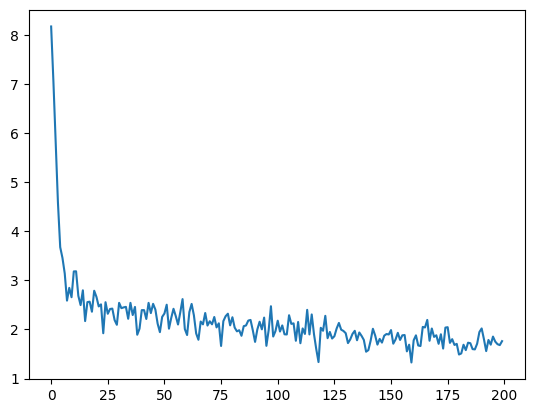

 PREDICTION: This song features a female vocalist singing along with a male vocalist singing along with a male 
vocalist singing along with a male vocalist singing along with a male vocalist singing along with a male vocalist 
singing along with a male vocalist singing along with a male vocalist singing along with a male vocalist singing 
along with a male vocalist singing along with a male vocalist singing along with a male vocalist singing along with
a male vocalist singing along with a male vocalist singing along with a male vocalist singing along with a male 
vocalist singing along with a male vocalist singing along with a male vocalist singing

 TRUE CAPTION: The music features a female voice that sings in a theatrical style, similar to Broadway musicals. 
The bass guitar and drums blend together and play a light accompaniment. A piano can also be heard contributing to 
the overall accompaniment. A string section plays a long note melody that transitions into playing in unison with 
the singer's melody.

 PREDICTION: The low quality recording features a low quality recording of an acoustic guitar playing a melody. The
low quality recording features a low quality recording of an acoustic guitar playing a melody. The low quality 
recording features a low quality recording of an acoustic guitar playing a melody. The low quality recording 
features a low quality recording of an acoustic guitar playing a melody. The low quality recording features a low 
quality recording of an acoustic guitar playing a melody. The low quality recording features a low quality 
recording of an acoustic guitar playing a melody. The low quality recording features a low quality recording of an 
acoustic guitar playing a melody. The low quality recording features a low quality

 TRUE CAPTION: The low quality recording features an electric guitar melody, with echoing wobble effect on, that 
occasionally distorts. It sounds like the player is trying out an effect for his guitar.

 PREDICTION: The low quality recording features a male vocalist singing in a low pitched, low pitched, low pitched,
low pitched, low pitched, low pitched, low pitched, low pitched, low pitched, low pitched, low pitched, low 
pitched, low pitched, low pitched, low pitched, low pitched, low pitched, low pitched, low pitched, low pitched, 
low pitched, low pitched, low pitched, low pitched, low pitched, low pitched, low pitched, low pitched, low 
pitched, low pitched, low pitched, low pitched, low pitched, low pitched, low pitched, low pitched, low pitched, 
low pitched, low

 TRUE CAPTION: This instrumental song starts off with a repetitive synth melody and percussion. The percussion 
pauses and the sound of water splash is heard. The bass note continues to ring. During this pause, a three-note 
high pitched game sound is played. After the pause, the synth melody continues to play and a piano melody is played
on top of that. The bass plays the root notes of the chords. The percussion plays a simple beat in common time.

 PREDICTION: The low quality recording features a male vocalist singing a melody. The recording is low quality. The
recording may be playing a live performance.

 TRUE CAPTION: Amateur recording of two nylon string guitars playing in flamenco style. The playing is technically 
challenging yet sloppy.

 PREDICTION: The low quality recording features a live performance of a folk song. The song is a folk song. The 
song is a folk song. The song is a folk song. The song is a folk song. The song is a folk song. The song is a folk 
song. The song is a folk song. The song is a folk song. The song is a folk song. The song is a folk song. The song 
is a folk song. The song is a folk song. The song is a folk song. The song is a folk song. The song is a folk song.
The song is a folk song. The song

 TRUE CAPTION: A full orchestra is playing a slow dramatic, emotional and soft composition. In the background 
whispering can be heard. This is an amateur recording. This song may be playing at a theater dancing ballet.

 PREDICTION: The low quality recording features a live performance of a pop song. The recording is noisy and it 
sounds like it is being played in a live performance.

 TRUE CAPTION: This song contains mallet instruments playing a fast melody in the mid and high register along with 
low notes as bassline. The marimba is full of reverb. Then a bass drum comes in playing on every beat. This song 
may be playing in an advertisement.

 PREDICTION: The low quality recording features a live performance of a folk song. The recording is noisy and it is
accompanied by an electric guitar playing a melody. The recording is accompanied by an electric guitar playing a 
melody. The recording is accompanied by an electric guitar playing a melody. The recording is accompanied by an 
electric guitar playing a melody. The recording is accompanied by an electric guitar playing a melody. The 
recording is accompanied by an electric guitar playing a melody. The recording is accompanied by an electric guitar
playing a melody. The recording is accompanied by an electric guitar playing a melody. The recording is accompanied
by an electric guitar playing a melody. The recording

 TRUE CAPTION: This audio contains someone playing a theremin. Playing around with the pitch. This may be playing 
in a comedic act.

 PREDICTION: The low quality recording features a live performance of a folk song. The recording is noisy and it is
accompanied by an electric guitar solo. The recording is accompanied by an electric guitar solo. The recording is 
accompanied by an electric guitar solo. The recording is accompanied by an electric guitar solo. The recording is 
accompanied by an electric guitar solo. The recording is accompanied by an electric guitar solo. The recording is 
accompanied by an electric guitar solo. The recording is accompanied by an electric guitar solo. The recording is 
accompanied by an electric guitar solo. The recording is accompanied by an electric guitar solo. The recording is 
accompanied by an electric guitar solo.

 TRUE CAPTION: The low quality recording features a jazzy electric guitar melody. The recording is noisy and it is 
in mono - regardless, it sounds calming and relaxing.

 PREDICTION: The low quality recording features a live performance of a folk song. It consists of a female vocal 
singing a melody that is being played by a male vocal. The recording is noisy and it is accompanied by a piano 
accompaniment.

 TRUE CAPTION: The low quality recording features a gospel song that consists of harmonizing mixed choir singing. 
The recording is noisy, in mono and it sounds passionate, joyful, soulful and reverberant.

 PREDICTION: The low quality recording features a live performance of an acoustic guitar. It sounds energetic and 
energetic. The recording is noisy and noisy.

 TRUE CAPTION: This is a percussion music piece. There is a medium pitched conga sound providing the rhythm. 
Clicking sounds related to a video game can be heard. Parts of this piece are suitable for a video game.soundtrack.

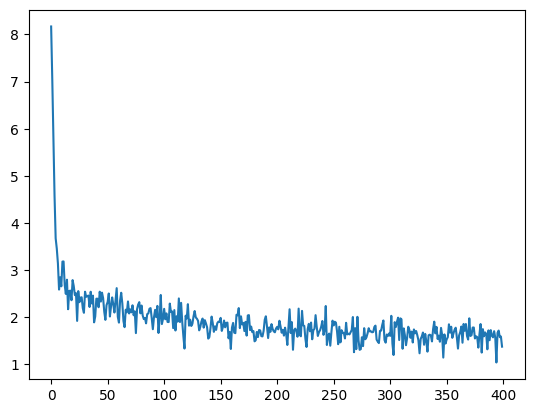

 PREDICTION: The low quality recording features a live performance of a folk song. The recording is noisy and the 
recording equipment is broken. The recording is noisy and the recording quality is poor.

 TRUE CAPTION: This relaxing song features the sound of pads in the background. A guitar strums a chord first then 
plays arpeggiated chords. At the end of the song, a piano chord is played. A wave-like synth plays one continuous 
note in the background. The bass plays the root notes of the chords and the note lingers. The mood of this song is 
relaxing. This song can be played in a spa.

 PREDICTION: The low quality recording features a live performance of an acoustic guitar melody. It is noisy and 
noisy.

 TRUE CAPTION: The low quality recording features a solo still guitar melody. The recording is a bit noisy and it 
sounds like it is a live performance. There are also some pluck and string sounds as the instruments are being 
played.

 PREDICTION: The low quality recording features a live performance of a folk song. It sounds passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate,

 TRUE CAPTION: This music is an Indian classical instrumental. The tempo is fast with an animated Sitar lead, 
supported with rhythmic beats of lively tabla and dholak , along with a soft and subtle keyboard accompaniment. The
music is upbeat, vibrant, vivacious, vigorous , engaging and captivating. This instrumental is a Hindustani 
classical.

 PREDICTION: The low quality recording features a live performance of a female vocal singing over a groovy bass 
line. It sounds passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate

 TRUE CAPTION: A female voice is singing emotionally along to an acoustic piano. In the background you can hear 
people laughing. This song may be playing in a tv-show.

 PREDICTION: The song is an instrumental. The tempo is fast with a lot of percussion and a lot of percussion 
sounds. The song is loud and energetic. The song is an instrumental. The song can be heard in the background of a 
movie.

 TRUE CAPTION: A classical composition containing strings playing a short repeating melody. You can hear a lot of 
background noises that seem to come from cars racing. This is an amateur recording. This song may be playing 
sitting in a limousine.

 PREDICTION: The low quality recording features a live performance of a folk song. The recording is noisy and it is
accompanied by an electric guitar solo. The recording is accompanied by an electric guitar solo. The recording is 
accompanied by an electric guitar solo. The recording is accompanied by an electric guitar solo. The recording is 
accompanied by an electric guitar solo. The recording is accompanied by an electric guitar solo. The recording is 
accompanied by an electric guitar solo. The recording is accompanied by an electric guitar solo. The recording is 
accompanied by an electric guitar solo. The recording is accompanied by an electric guitar solo. The recording is 
accompanied by an electric guitar solo.

 TRUE CAPTION: The low quality recording features a female opera vocalist singing over sustained strings. There is 
tinny metallic percussive foley at one point in the loop. It is a bit quiet, but it also sounds dynamic, emotional 
and passionate.

 PREDICTION: The low quality recording features a live performance of a folk song. It sounds energetic and 
energetic. It sounds like it was recorded in the 70's.

 TRUE CAPTION: A male voice is singing loud and in a higher register while a flute is playing a counter melody. 
Percussions are playing a fast paced groove along with a soft minimalistic bass. In the background you can hear a 
synth pad playing chords. This song may be playing in a oriental barber shop.

 PREDICTION: The low quality recording features an electric guitar melody playing in the background. It sounds like
it was recorded in a cave. It sounds like it could be used in the soundtrack of a movie.

 TRUE CAPTION: This audio contains someone playing a tibetan bowl ringing in a high pitch. This may be playing 
during meditation.

 PREDICTION: The low quality recording features a live performance of a folk song. It sounds passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate,

 TRUE CAPTION: This folk song features the lead melody played on a rebab instrument which sounds like violins. This
song has a Middle-Eastern melody. This is accompanied by traditional Middle-Eastern percussion. A tambourine is 
played in the background. The other instruments are not clear due to the low quality of the audio. There are no 
voices in this song. This is an instrumental song. This song can be played at a village scene in a movie.

 PREDICTION: The low quality recording features a live performance of a folk song. It sounds emotional, emotional, 
emotional, emotional, emotional, emotional, emotional, emotional, emotional, emotional, emotional, emotional, 
emotional, emotional, emotional, emotional, emotional, emotional, emotional, emotional, emotional, emotional, 
emotional, emotional, emotional, emotional, emotional, emotional, emotional, emotional, emotional, emotional, 
emotional, emotional, emotional, emotional, emotional, emotional, emotional, emotional, emotional, emotional, 
emotional, emotional, emotional, emotional, emotional, emotional, emotional, emotional, emotional, emotional, 
emotional, emotional, emotional, emotional,

 TRUE CAPTION: This music is a violin instrumental. The tempo is medium fast with the violins going from lively to 
soft with a romantic piano melody and acoustic guitar accompaniment. The music is orchestral with a dulcet violin 
symphony. It is pleasant, mellifluous, passionate, romantic; euphonious, emotional, sweet and engaging. This music 
is a contemporary orchestra .

In [ ]:
for step in tqdm(itertools.count(0, 1)):
    captions, captions_tok, embs, epoch = next(batcher)

    patch_enabled = True
    loss = model(fake_pixel_values, labels=captions_tok).loss
    patch_enabled = False
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    losses.append(loss.item())
    
    if step % 20 == 0:
        output_ids = model.generate(fake_pixel_values[0:1], max_length=128, num_beams=2)
        printr('[blue bold] PREDICTION: ' + tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip())
        printr('[green bold] TRUE CAPTION: ' + captions[0])
        print()
    
    if step % 200 == 199:
        plt.plot(losses)
        plt.show()

In [7]:
def patched_forward(*args, **kwargs):
    for arg in args:
        if not arg is None:
            print(type(arg))
    for k, v in kwargs.items():
        if not v is None:
            print(k, type(v))
    print('---- RETURN VAL ---')
    result = f(*args, **kwargs)
    print(type(result))
    for k in result:
        print(k, getattr(result, k).shape)
    print('\n'*3)
    result.last_hidden_state[:] = torch.randn_like(result.last_hidden_state)*0.3
    return result

model.encoder.forward = patched_forward

In [156]:
f??

Signature:
f(
    pixel_values: Optional[torch.Tensor] = None,
    bool_masked_pos: Optional[torch.BoolTensor] = None,
    head_mask: Optional[torch.Tensor] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    interpolate_pos_encoding: Optional[bool] = None,
    return_dict: Optional[bool] = None,
) -> Union[Tuple, transformers.modeling_outputs.BaseModelOutputWithPooling]
Docstring:
The [`ViTModel`] forward method, overrides the `__call__` special method.

<Tip>

Although the recipe for forward pass needs to be defined within this function, one should call the [`Module`]
instance afterwards instead of this since the former takes care of running the pre and post processing steps while
the latter silently ignores them.

</Tip>

Args:
    pixel_values (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)`):
        Pixel values. Pixel values can be obtained using [`AutoImageProcessor`]. See [`ViTImageProcessor.__call

In [251]:
model.forward??

Signature:
model.forward(
    pixel_values: Optional[torch.FloatTensor] = None,
    decoder_input_ids: Optional[torch.LongTensor] = None,
    decoder_attention_mask: Optional[torch.BoolTensor] = None,
    encoder_outputs: Optional[Tuple[torch.FloatTensor]] = None,
    past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
    decoder_inputs_embeds: Optional[torch.FloatTensor] = None,
    labels: Optional[torch.LongTensor] = None,
    use_cache: Optional[bool] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    return_dict: Optional[bool] = None,
    **kwargs,
) -> Union[Tuple[torch.FloatTensor], transformers.modeling_outputs.Seq2SeqLMOutput]
Docstring:
The [`VisionEncoderDecoderModel`] forward method, overrides the `__call__` special method.

<Tip>

Although the recipe for forward pass needs to be defined within this function, one should call the [`Module`]
instance afterwards instead of this since the former takes care

In [250]:
model(pixel_values, labels=output_ids)

<class 'torch.Tensor'>
return_dict <class 'bool'>
---- RETURN VAL ---
<class 'transformers.modeling_outputs.BaseModelOutputWithPooling'>
last_hidden_state torch.Size([1, 197, 768])
pooler_output torch.Size([1, 768])






Seq2SeqLMOutput(loss=tensor(2.3366, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[[ -35.8679,  -26.7638,  -27.6791,  ...,  -47.7585,  -43.8306,
           -32.5497],
         [ -42.1690,  -32.1792,  -33.5180,  ...,  -53.5255,  -48.5961,
           -37.6655],
         [ -32.6727,  -30.1231,  -34.8829,  ...,  -42.8414,  -30.4824,
           -30.9890],
         ...,
         [ -46.9919,  -44.8377,  -49.4250,  ...,  -55.7228,  -49.0115,
           -45.0781],
         [ -62.6528,  -61.6987,  -66.5732,  ...,  -79.3381,  -68.3395,
           -59.0497],
         [-125.0046, -122.8182, -127.5253,  ..., -142.7821, -135.1219,
           -94.1819]]], device='cuda:0', grad_fn=<UnsafeViewBackward0>), past_key_values=((tensor([[[[-0.4639,  1.0217,  0.5178,  ..., -1.3494,  0.0604,  0.9517],
          [-0.8643,  0.9492,  1.7128,  ..., -1.6513, -0.4688,  1.2078],
          [-1.5492,  2.0069,  1.2288,  ..., -0.7368, -1.7374,  1.7684],
          ...,
          [-2.2556,  2.2525,  1.3288,  

In [239]:
output_ids = model.generate(pixel_values, **gen_kwargs)
tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()

output_attentions <class 'bool'>
output_hidden_states <class 'bool'>
return_dict <class 'bool'>
pixel_values <class 'torch.Tensor'>
---- RETURN VAL ---
<class 'transformers.modeling_outputs.BaseModelOutputWithPooling'>
last_hidden_state torch.Size([1, 197, 768])
pooler_output torch.Size([1, 768])






'a person standing next to a pile of luggage'

In [111]:
handle.remove()
def hook(m, input, output):
    print(type(m))
    print('Input shapes', type(input), len(input))
    
    if isinstance(input, tuple):
        for x in input:
            print(type(x))
    print('Output shapes')
    
    print(type(output))
    
    
    print(output.shape)

handle = model.decoder.register_forward_hook(hook)

In [119]:

image_path = 'croissant.jpg'
image = Image.open(image_path)
if image.mode != "RGB":
    image = image.convert(mode="RGB")
pixel_values = feature_extractor(images=[image], return_tensors="pt").pixel_values.to(device)